# Part 2 - Plotting photon energy spectra in a histogram form

This example creates a simple sphere of tungsten and tallies the photons in two different ways:

- Photon flux averaged across the cell
- Photon current on the rear surface

This section creates a simple material, geometry and settings. This model is used in both the photon current tally and photon flux tally.

In [1]:
import openmc

# MATERIALS

# Tungsten is a very good photon shield, partly due to its high Z number and electrons
my_material = openmc.Material(name='tungsten')
my_material.add_element('W', 1, percent_type='ao')
my_material.set_density('g/cm3', 19)

mats = openmc.Materials([my_material])


# GEOMETRY

# surfaces
vessel_inner_surface = openmc.Sphere(r=500)
vessel_rear_surface = openmc.Sphere(r=530)
# Currently it is not possible to tally on boundary_type='vacuum' surfaces
outer_surface = openmc.Sphere(r=550, boundary_type='vacuum')

# cells
inner_vessel_cell = openmc.Cell(region=-vessel_inner_surface)
# inner_vessel_cell is filled with a void / vacuum by default

blanket_cell = openmc.Cell(region=-vessel_rear_surface & +vessel_inner_surface)
blanket_cell.fill = my_material

outer_vessel_cell = openmc.Cell(region=+vessel_rear_surface & -outer_surface)
# this is filled with a void / vacuum by default

universe = openmc.Universe(cells=[inner_vessel_cell,blanket_cell, outer_vessel_cell])
geom = openmc.Geometry(universe)


# SIMULATION SETTINGS

# Instantiate a Settings object
sett = openmc.Settings()
sett.batches = 100
sett.inactive = 0 # the default is 10, which would be wasted computing for us
sett.particles = 1000
sett.run_mode = 'fixed source'
sett.photon_transport = True  # This line is required to switch on photons tracking


# Create a DT point source
source = openmc.Source()
source.space = openmc.stats.Point((0, 0, 0))
source.angle = openmc.stats.Isotropic()
# neutron is the default source.particle value so this line is not actually necessary for the simulation.
# However it is added for clarity.
# This simulation has a neutron source and those neutrons generate photons via interactions with the material.
# The resulting photons energy spectrum is tallied, but the units are still per source netron.
source.particle = 'neutron' 
source.energy = openmc.stats.Discrete([14e6], [1])
sett.source = source

This section section adds a tally for the average photon flux across a cell.

In [2]:
#creates an empty tally object
tallies = openmc.Tallies()

# sets up filters for the tallies
neutron_particle_filter = openmc.ParticleFilter(['photon'])  # note the use of photons here
energy_bins = openmc.mgxs.GROUP_STRUCTURES['VITAMIN-J-175']
energy_filter = openmc.EnergyFilter(energy_bins)


# setup the filters for the cell tally
cell_filter = openmc.CellFilter(blanket_cell) 

# create the tally
cell_spectra_tally = openmc.Tally(name='cell_spectra_tally')
cell_spectra_tally.scores = ['flux']
cell_spectra_tally.filters = [cell_filter, neutron_particle_filter, energy_filter]
tallies.append(cell_spectra_tally)

This section runs the simulation.

In [3]:
# combine all the required parts to make a model
model = openmc.model.Model(geom, mats, sett, tallies)

# remove old files and runs OpenMC
!rm *.h5
results_filename = model.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

This section extracts the cell tally data from the results file and plots photon flux across the cell.

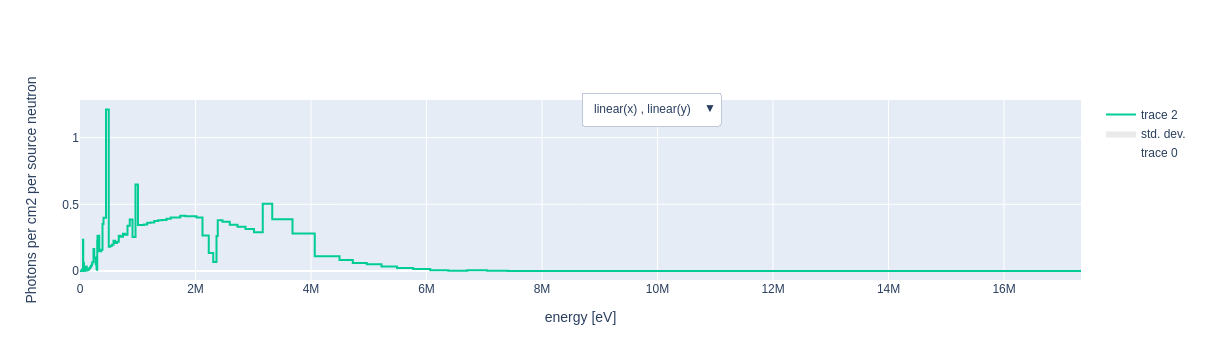

In [6]:
# open the results file
results = openmc.StatePoint(results_filename)

#extracts the tally values from the simulation results
cell_tally = results.get_tally(name='cell_spectra_tally')

# imports a convenient plotting package
from spectrum_plotter import plot_spectra

plot_spectra(
    spectra=cell_tally,
    x_label = "energy [eV]",
    y_label = "Photons per cm2 per source neutron",
    plotting_package="plotly",  # matplotlib is another option, but plotly option provides a dropdown menu for changing axis scale
)

- In this simulation we used the VITAMIN-J-175 energy group structure to tally neutrons in energy bins.
- There are several group structures built into OpenMC.
- I added the VITAMIN-J-175, CCFE-709 and UKAEA-1102 structures to the OpenMC source code - these are popular in fusion energy and it makes using them more convenient if they are in the source code.
- OpenMC source code with other group structures can be found here: https://github.com/openmc-dev/openmc/blob/develop/openmc/mgxs/__init__.py.

**Learning Outcomes for Part 2:**

- OpenMC can perform coupled neutron-photon simulations where photons are created from neutron interactions.
- Photon spectra can be tallied in OpenMC using flux or current tallies, and energy bins.